In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../do-mpc/')
import do_mpc
import pandas as pd
import scipy.io as sio
import pathlib

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from nn_tools import NNPredictModel

In [2]:
%matplotlib notebook

# Load data

In [3]:
plans = []

names = ['kite_sampling_01']

dh_list = []
res = []
for name in names:
    load_name = '../sampling/{name}/{name}_plan.pkl'.format(name=name)
    plan = do_mpc.tools.load_pickle(load_name)
    
    dh = do_mpc.sampling.DataHandler(plan)
    dh.set_param(data_dir = '../sampling/{}/sample_results/'.format(name))

    dh.set_post_processing('input', lambda data: data['_u'])
    dh.set_post_processing('states', lambda data: data['_x'])
    dh.set_post_processing('wind', lambda data: data['_p'])
    dh.set_post_processing('T_F', lambda data: data['_aux', 'T_F'])
    dh.set_post_processing('height', lambda data: data['_aux', 'height_kite'])
    dh.set_post_processing('traj_len', lambda data: data['_x'].shape[0])
    dh_list.extend(dh)
    res.extend(dh.filter(input_filter = lambda w_ref, E_0: np.abs(w_ref-10)<2 and np.abs(E_0-6)<2,
                        output_filter = lambda T_F: np.sum(T_F)/1e6>20))



---------------------------------------------------------------
Trying to access a non-existent element from the sampling plan.
---------------------------------------------------------------


In [4]:
len(res)

38

Only include data that satisfies certain conditions:

In [5]:
res_pd = pd.DataFrame(res)
res_pd.head(3)

,w_ref,E_0,h_min,seed,x0,id,input,states,wind,T_F,height,traj_len
0,10.953643,6.091611,95.100967,463,"[[1.2192922329037863], [0.6996672143951623], [...",000,"[[6.862405355210816], [9.353320432506655], [10...","[[1.2192922329037863, 0.6996672143951623, -0.3...","[[6.0872768549427425, 10.487860180192119], [6....","[[18929.338122699362], [11672.844666683484], [...","[[287.3111352903893], [287.07290665482753], [2...",200
1,8.294952,7.287200,111.246471,765,"[[0.7322457690565014], [0.8926083891975454], [...",004,"[[5.3955285783777365], [7.560199882010559], [8...","[[0.7322457690565014, 0.8926083891975454, 0.22...","[[7.265006093980835, 8.603838193907485], [7.25...","[[222066.8455218631], [167634.00237900967], [1...","[[167.77260931599628], [171.3633801694216], [1...",200
2,10.789213,7.754743,99.776706,268,"[[0.8527867049570851], [0.3678638736816997], [...",005,"[[6.163782180866716], [7.876381663746424], [8....","[[0.8527867049570851, 0.3678638736816997, 1.76...","[[7.741991467576186, 9.899266035689228], [7.74...","[[217013.27544139975], [181299.7142971376], [1...","[[281.09256299402824], [281.6685548120641], [2...",200


<IPython.core.display.Javascript object>


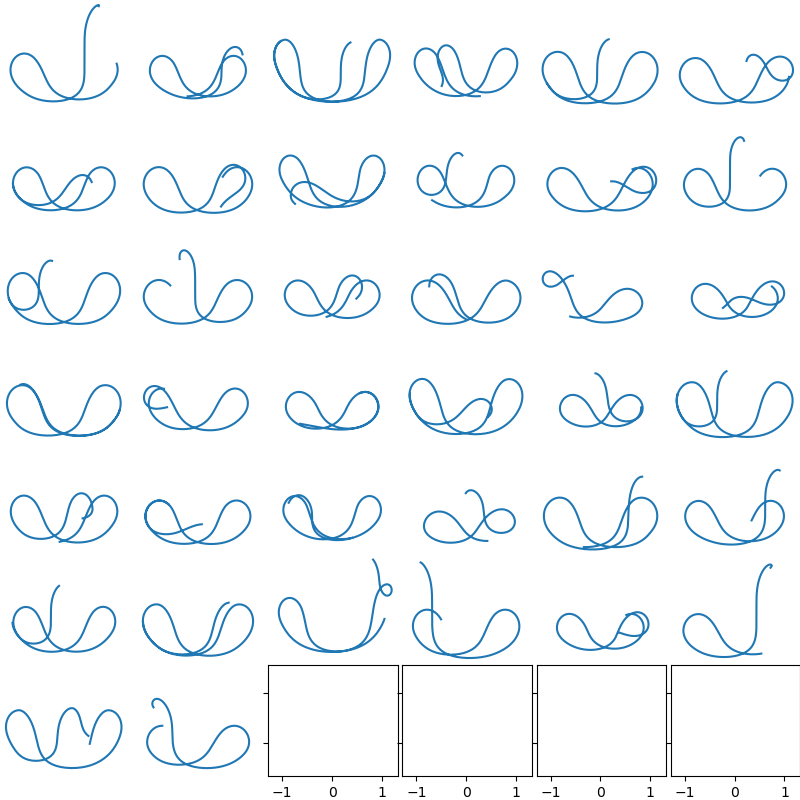

In [6]:
n_res = min(len(res),80)

n_row = int(np.ceil(np.sqrt(n_res)))
n_col = int(np.ceil(n_res/n_row))


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(8,8))
for i, res_i in enumerate(res):
    try:
        ax[i//n_col, np.mod(i,n_col)].plot(res_i['states'][:,1],res_i['states'][:,0])
        ax[i//n_col, np.mod(i,n_col)].axis('off')
    except:
        break
    
    
fig.tight_layout(pad=0)


# Data prep

In [17]:
nn_in = []
nn_out = []

n_test = 20
train_val_res = res[:-n_test]
test_res = res[-n_test:]


for i, res_i in enumerate(train_val_res):
    x_now = res_i['states'][:,:] # omit position as state

    nn_in.append(np.concatenate((res_i['input'], res_i['wind'], x_now),axis=1)[:-1,:])


    x_next = np.roll(res_i['states'],-1,axis=0)[:,:]
    dx = x_next - x_now

    nn_out.append(np.concatenate((res_i['T_F'], res_i['height'], dx),axis=1)[:-1,:])

n_traj = len(res)
    
    

    
nn_in = np.concatenate(nn_in)
nn_out = np.concatenate(nn_out)

nn_in_train, nn_in_test, nn_out_train, nn_out_test = train_test_split(nn_in, nn_out, test_size=0.1, random_state=42)


# Noise
np.random.seed(99)
noise_mag = 0.0
in_noise = np.mean(np.abs(nn_in_train),axis=0)*noise_mag
out_noise = np.mean(np.abs(nn_out_train),axis=0)*noise_mag

nn_in_train += in_noise*np.random.randn(*nn_in_train.shape)
nn_out_train += out_noise*np.random.randn(*nn_out_train.shape)
nn_in_test += in_noise*np.random.randn(*nn_in_test.shape)
nn_out_test += out_noise*np.random.randn(*nn_out_test.shape)

In [18]:
in_scaler = preprocessing.StandardScaler().fit(nn_in_train)
out_scaler = preprocessing.StandardScaler().fit(nn_out_train)

nn_in_train_scaled = in_scaler.transform(nn_in_train)
nn_out_train_scaled = out_scaler.transform(nn_out_train)

nn_in_test_scaled = in_scaler.transform(nn_in_test)
nn_out_test_scaled = out_scaler.transform(nn_out_test)

nn_in_train_scaled.shape

(3223, 6)

In [19]:
def get_keras_model(architecture, activation='relu', l1=0, l2=0):
    """Function to obtain a Keras model
    
    Model is defined by the parameter ``architecture`` which must be a list. 
    
    Example:
        
        architecture = [1, 5, 5, 1]
        
    Returns a NN with one input, two hidden layers (each with 5 neurons) and one output.
    
    All hidden layer (except for the output layer) have the same activation function.
    """
    inputs = keras.Input(shape=architecture[0], name='input')
    outputs = [inputs]
    
    for n_l in range(1, len(architecture)-1):
        outputs.append(keras.layers.Dense(architecture[n_l], 
                                 activation=activation,
                                 activity_regularizer=keras.regularizers.l1_l2(l1=l1, l2=l2),
                                 name='hidden_{}'.format(n_l))(outputs[n_l-1]))
        
    outputs.append(keras.layers.Dense(architecture[-1], 
                                      name='output')(outputs[-1]))
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs[-1])
    
    return model, outputs

In [20]:
np.random.seed(99)
tf.random.set_seed(99)

architecture = [nn_in_train.shape[1], 20,20, nn_out_train.shape[1]]

nn_model, outputs = get_keras_model(architecture, 'tanh')

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MSE,
)

activation_model = tf.keras.Model(inputs=outputs[0],outputs=outputs[-2])

In [21]:
history = nn_model.fit(
    nn_in_train_scaled, 
    nn_out_train_scaled,
    validation_data = (nn_in_test_scaled, nn_out_test_scaled),
    epochs=1000,
    batch_size=200,
)

Epoch 1/1000
17/17 [==============================] - 0s 7ms/step - loss: 1.3755 - val_loss: 1.0807
Epoch 2/1000
17/17 [==============================] - 0s 2ms/step - loss: 1.0142 - val_loss: 0.8162
Epoch 3/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.7641 - val_loss: 0.6543
Epoch 4/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.6255 - val_loss: 0.5556
Epoch 5/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.5262 - val_loss: 0.4932
Epoch 6/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.4812 - val_loss: 0.4541
Epoch 7/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.4523 - val_loss: 0.4283
Epoch 8/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.4371 - val_loss: 0.4116
Epoch 9/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.4093 - val_loss: 0.3980
Epoch 10/1000
17/17 [==============================] - 0s 3ms/step - loss: 0.4015 - val_loss: 0.3868

17/17 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 163/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 164/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0104
Epoch 165/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 166/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0102
Epoch 167/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 168/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0100
Epoch 169/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 170/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0099
Epoch 171/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 323/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 324/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 325/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 326/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 327/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 328/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 329/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 330/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 331/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 483/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 484/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 485/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 486/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 487/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 488/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 489/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 490/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 491/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 643/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 644/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 645/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 646/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 647/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 648/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 649/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 650/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 651/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 803/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 804/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 805/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 806/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 807/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 808/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 809/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 810/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 811/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.

17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 963/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 964/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 965/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 966/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 967/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 968/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 969/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 970/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 971/1000
17/17 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.

<IPython.core.display.Javascript object>


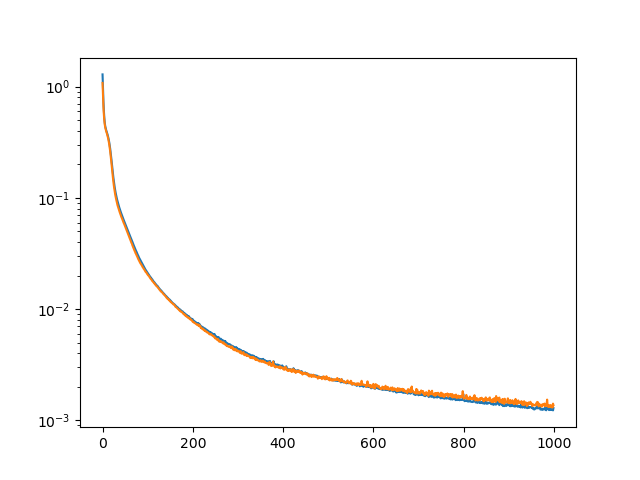

In [24]:
fig, ax = plt.subplots()
ax.semilogy(history.history['loss'], label='training loss')
ax.semilogy(history.history['val_loss'], label='validation loss')

In [25]:
case = 0

x0 = (test_res[case]['states'][0]).reshape(-1,1)
a_train = activation_model.predict(nn_in_train_scaled)

pm = NNPredictModel(nn_model, activation_model, 
                    a_train, in_scaler, out_scaler, x0,
                   sig_e=1, sig_w=1e3)

for k in range(test_res[case]['states'].shape[0]):
    u0 = test_res[case]['input'][k]
    p = test_res[case]['wind'][k]
    pm.make_step(u0,p)

<IPython.core.display.Javascript object>


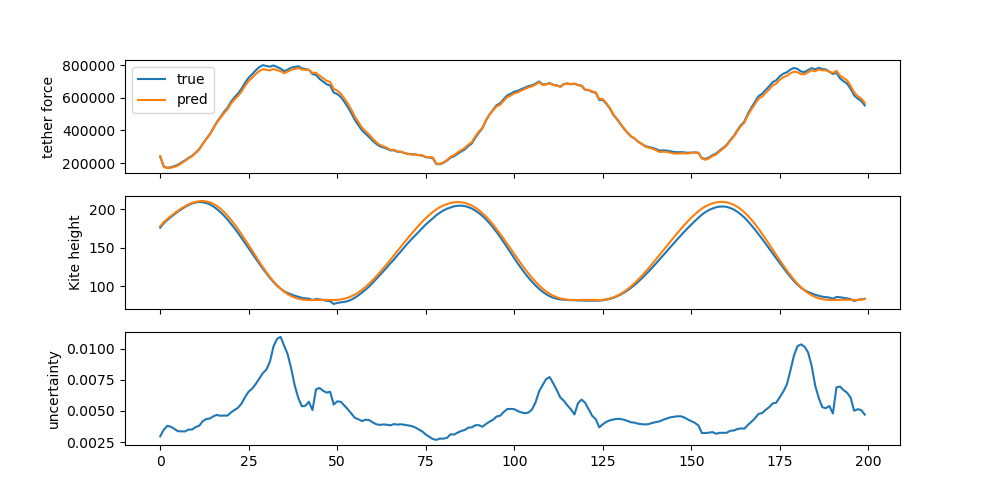

Text(0, 0.5, 'uncertainty')

In [26]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(10,5))

ax[0].plot(pm.aux[:,0],label='true')
ax[0].plot(test_res[case]['T_F'], label='pred')
ax[0].set_ylabel('tether force')
ax[0].legend()

ax[1].plot(pm.aux[:,1])
ax[1].plot(test_res[case]['height'])
ax[1].set_ylabel('Kite height')

ax[2].plot(pm.v)
ax[2].set_ylabel('uncertainty')

In [37]:
nn_traj = []
nn_trust = []
n_eval = min(20,len(test_res))

for i, res_i in enumerate(test_res[:n_eval]):
    x0 = (res_i['states'][0]).reshape(-1,1)
    pm.reset(x0)

    for k in range(res_i['states'].shape[0]):
        u0 = res_i['input'][k]
        p = res_i['wind'][k]
        pm.make_step(u0,p)
    
    nn_traj.append(pm.x)
    nn_trust.append(pm.v)

<IPython.core.display.Javascript object>


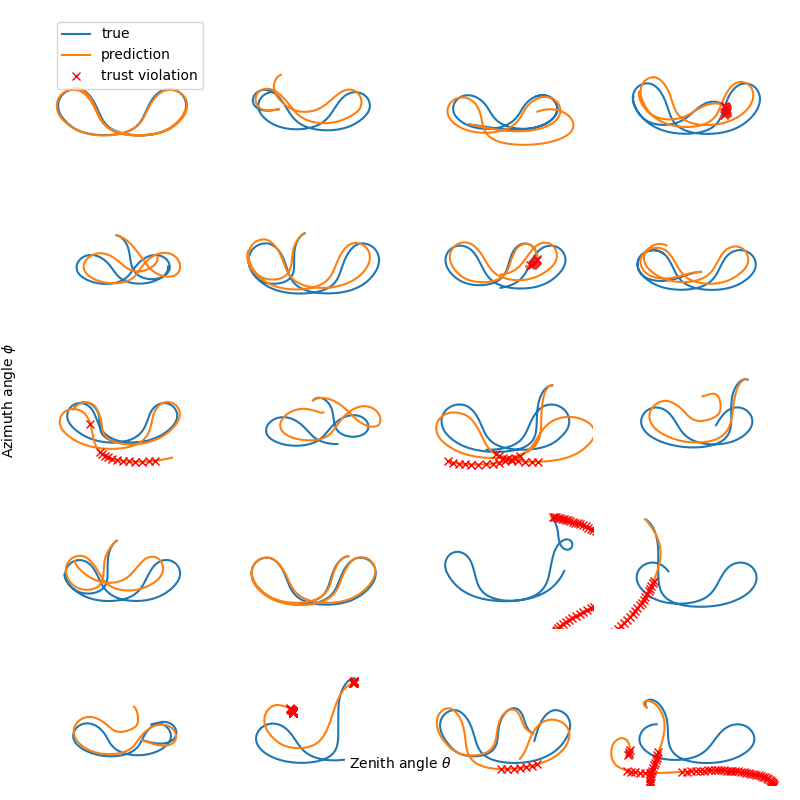

Text(-0.0, 0.5, 'Azimuth angle $\\phi$')

In [38]:
n_row = int(np.ceil(np.sqrt(n_eval)))
n_col = int(np.ceil(n_eval/n_row))

trust_threshold = 0.02


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(8,8))
for i, res_i in enumerate(test_res[:n_eval]):
    ax[i//n_col, np.mod(i,n_col)].plot(res_i['states'][:,1],res_i['states'][:,0], label='true')
    ax[i//n_col, np.mod(i,n_col)].plot(nn_traj[i][:,1], nn_traj[i][:,0], label='prediction')
    
    viol_ind = (nn_trust[i]>= trust_threshold).flatten()
    ax[i//n_col, np.mod(i,n_col)].plot(nn_traj[i][1:,:][viol_ind,1], nn_traj[i][1:,:][viol_ind,0],
                                      'x', color='red', label='trust violation')
    
    
for i in range(ax.size):
    ax[i//n_col, np.mod(i,n_col)].axis('off')

ax[0,0].legend()
ax[0,0].set_xlim(-np.pi/2,np.pi/2)
ax[0,0].set_ylim(0,np.pi/2)

fig.tight_layout()
fig.text(0.5, 0.04, r'Zenith angle $\theta$', ha='center')
fig.text(-0.0, 0.5, r'Azimuth angle $\phi$', va='center', rotation='vertical')


## Export model

In [171]:
export_name = 'S01_NN_M01'
export_path = './nn_models/{}/'
pathlib.Path(export_path.format(export_name)).mkdir(parents=True, exist_ok=True)

export_dict = {'a_train': a_train, 'in_scaler': in_scaler, 'out_scaler': out_scaler, 'C': pm.C}

do_mpc.tools.save_pickle(export_path.format(export_name) + export_name + '_aux.pkl', export_dict)

nn_model.save(export_path.format(export_name))

INFO:tensorflow:Assets written to: ./nn_models/S01_NN_M03/assets


In [39]:
np.sum(nn_traj)

-171.2210149152047

S01_NN_M01: -171.2210149152047